In [70]:
#!pip install skforecast

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Исследование и анализ временного ряда и визуализация
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Методы построения моделей временных рядов
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

plt.rcParams['figure.figsize'] = (15,8)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'

In [72]:
!unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [110]:
df = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

df = df.drop(['store', 'product'], axis = 1)
test = test.drop(['store', 'product'], axis = 1)

In [111]:
df.head()

,Date,number_sold
0,2010-01-01,801
1,2010-01-02,810
2,2010-01-03,818
3,2010-01-04,796
4,2010-01-05,808


In [112]:
df = df.groupby(['Date']).agg({'number_sold':'sum'}).reset_index()

In [113]:
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
df.index = df['Date']
df.index.name = None
df = df.drop('Date', axis = 1)

In [114]:
df.head()

,number_sold
2010-01-01,54870
2010-01-02,54960
2010-01-03,54863
2010-01-04,54926
2010-01-05,54634


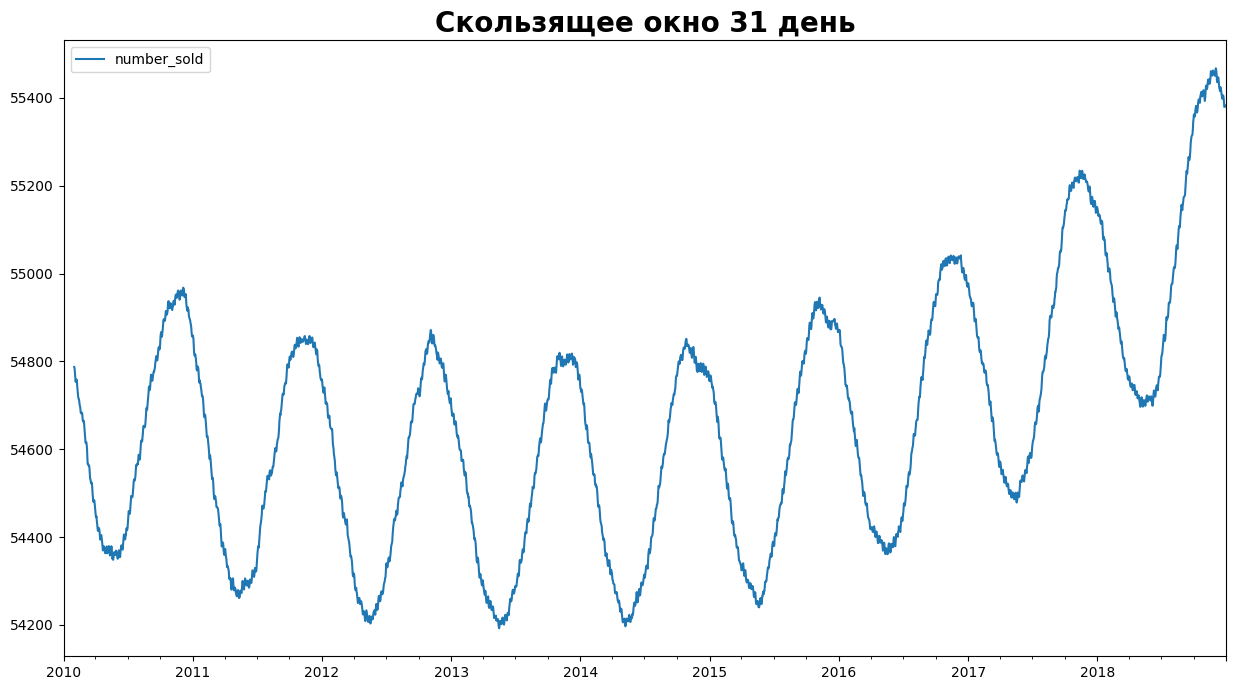

In [115]:
df.rolling(window = 31).mean().plot()
plt.title('Скользящее окно 31 день')
plt.show()

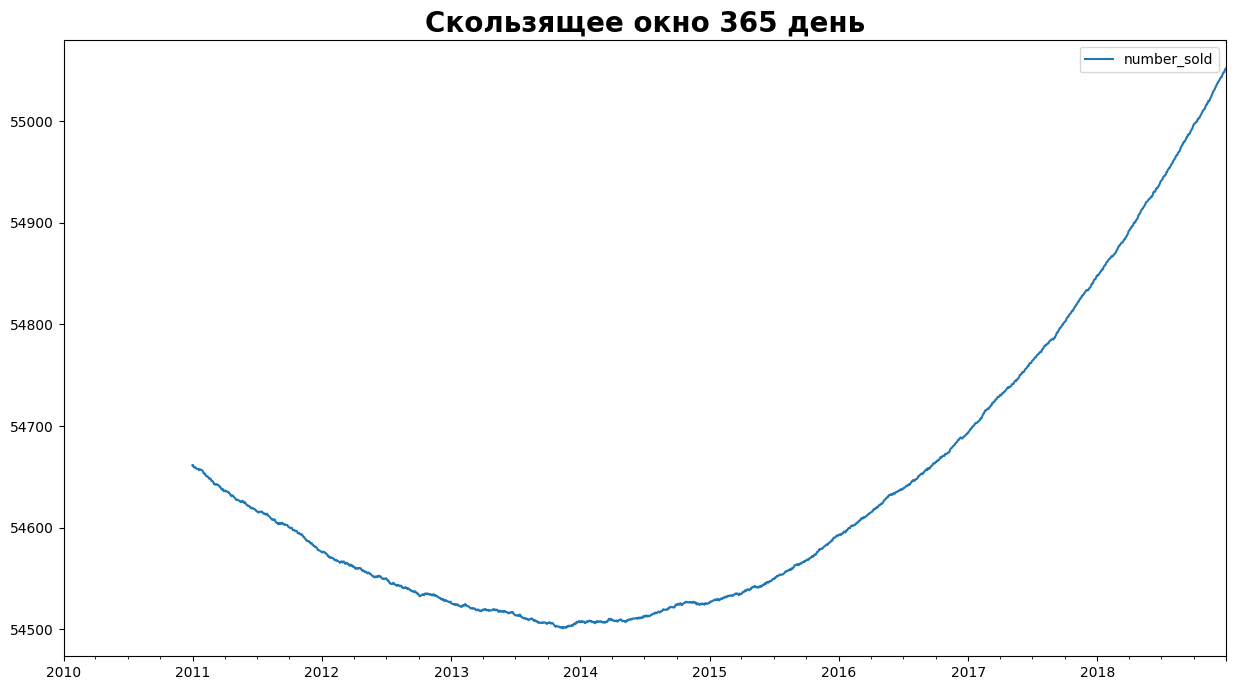

In [116]:
df.rolling(window = 365).mean().plot()
plt.title('Скользящее окно 365 день')
plt.show()

In [117]:
df.isna().sum()

number_sold    0
dtype: int64

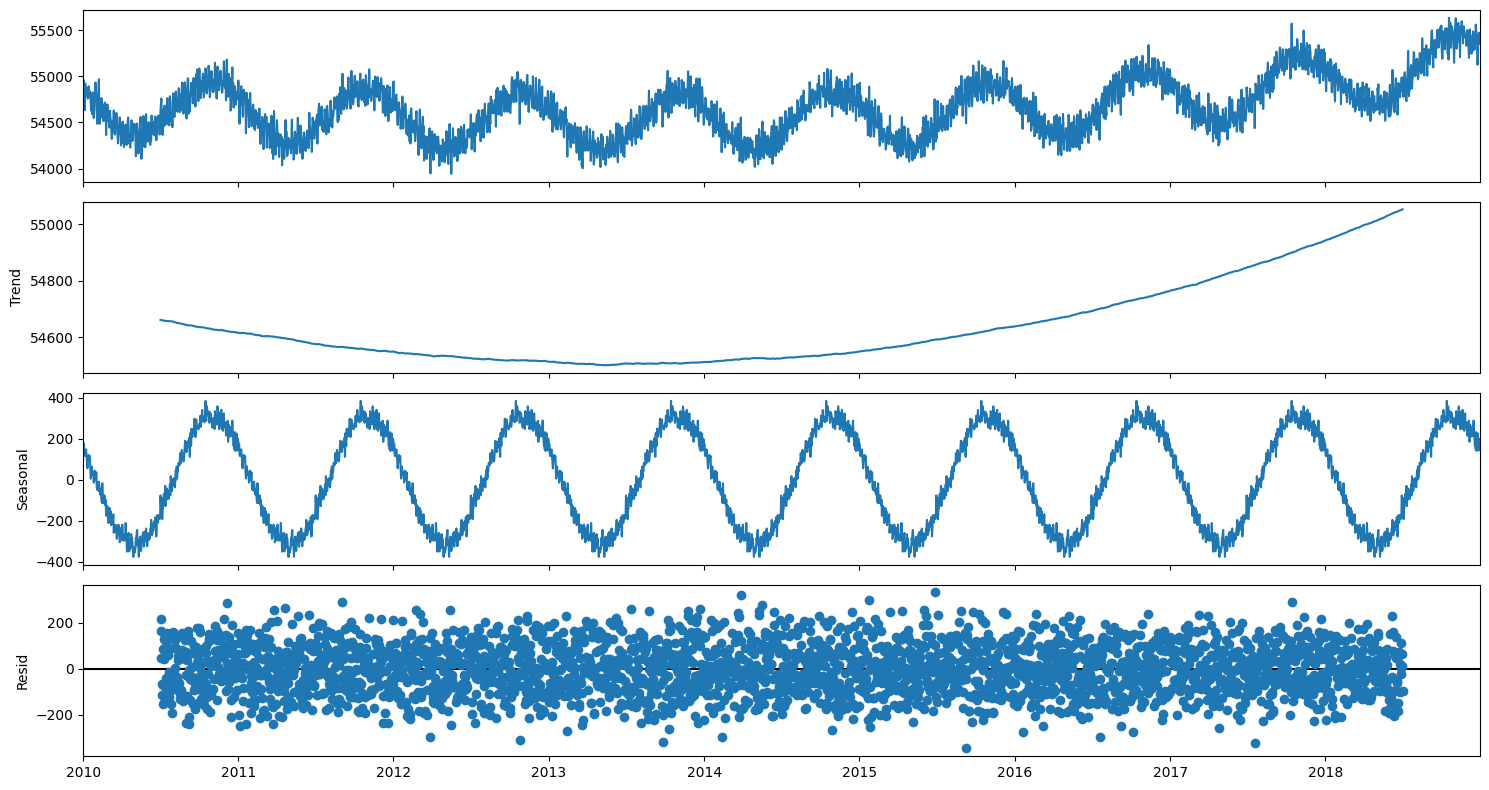

In [118]:
seasonal_decompose(df, model = 'additive', period = 365).plot()
plt.show()

In [119]:
# Тест Дики Фуллера
p_value = adfuller(df)[1]
print('p_value =', round(p_value,3))

p_value = 0.108


In [120]:
for i in range(1,8):
    string = "lag" + str(i)
    df[string] = df['number_sold'].shift(i, axis = 0)
df.head(10)

,number_sold,lag1,lag2,lag3,lag4,lag5,lag6,lag7
2010-01-01,54870,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,54960,54870.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,54863,54960.0,54870.0,NaN,NaN,NaN,NaN,NaN
2010-01-04,54926,54863.0,54960.0,54870.0,NaN,NaN,NaN,NaN
2010-01-05,54634,54926.0,54863.0,54960.0,54870.0,NaN,NaN,NaN
2010-01-06,54920,54634.0,54926.0,54863.0,54960.0,54870.0,NaN,NaN
2010-01-07,54853,54920.0,54634.0,54926.0,54863.0,54960.0,54870.0,NaN
2010-01-08,54791,54853.0,54920.0,54634.0,54926.0,54863.0,54960.0,54870.0
2010-01-09,54836,54791.0,54853.0,54920.0,54634.0,54926.0,54863.0,54960.0
2010-01-10,54872,54836.0,54791.0,54853.0,54920.0,54634.0,54926.0,54863.0


<Axes: >

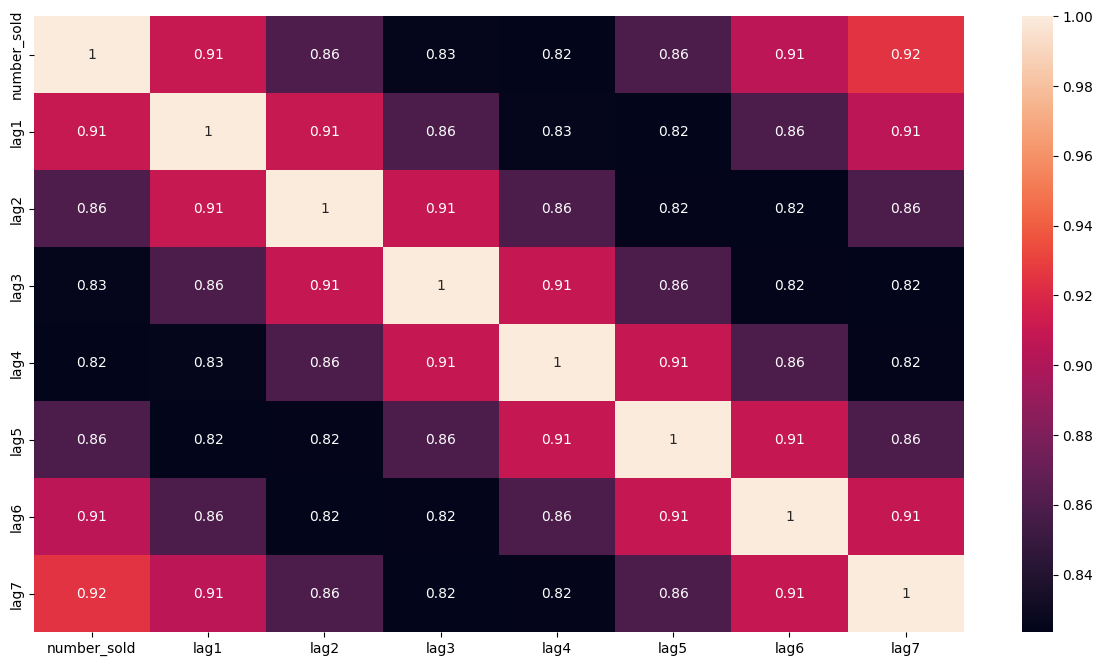

In [121]:
sns.heatmap(df.corr(), annot = True)

In [122]:
df = df.drop(df.columns[1:], axis = 1)

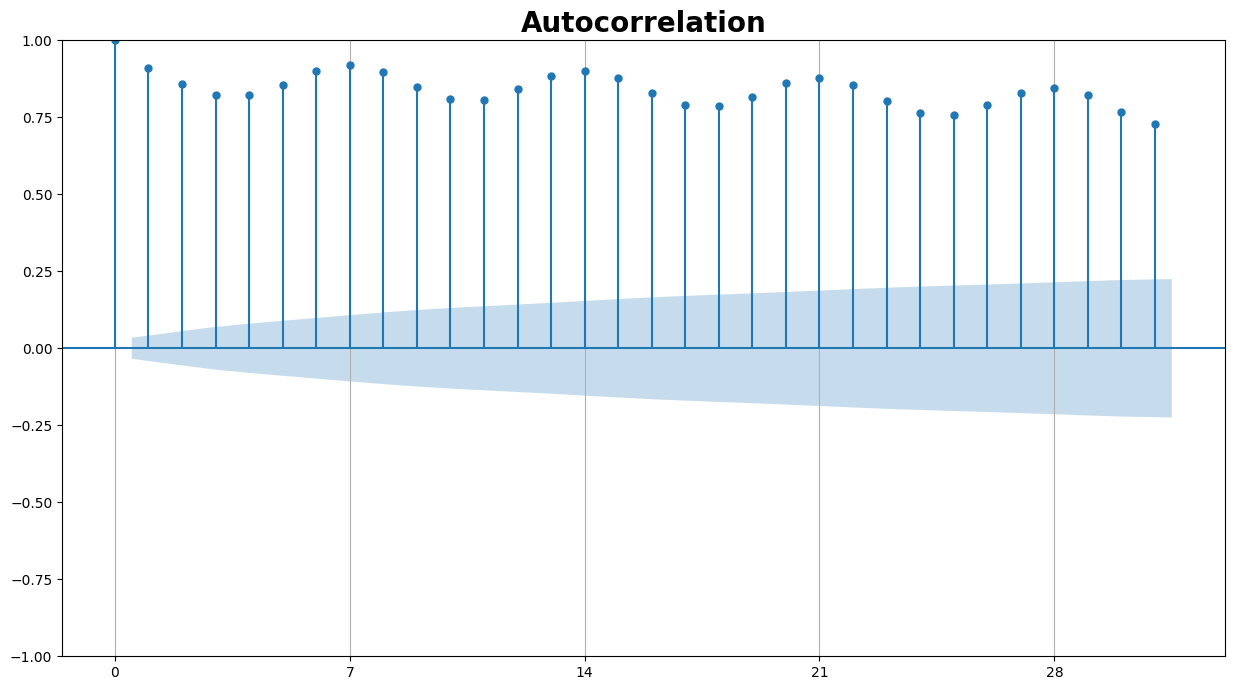

In [123]:
plot_acf(df, lags = 31)
plt.xticks(range(0,32,7))
plt.grid(True, axis = 'x')
plt.show()

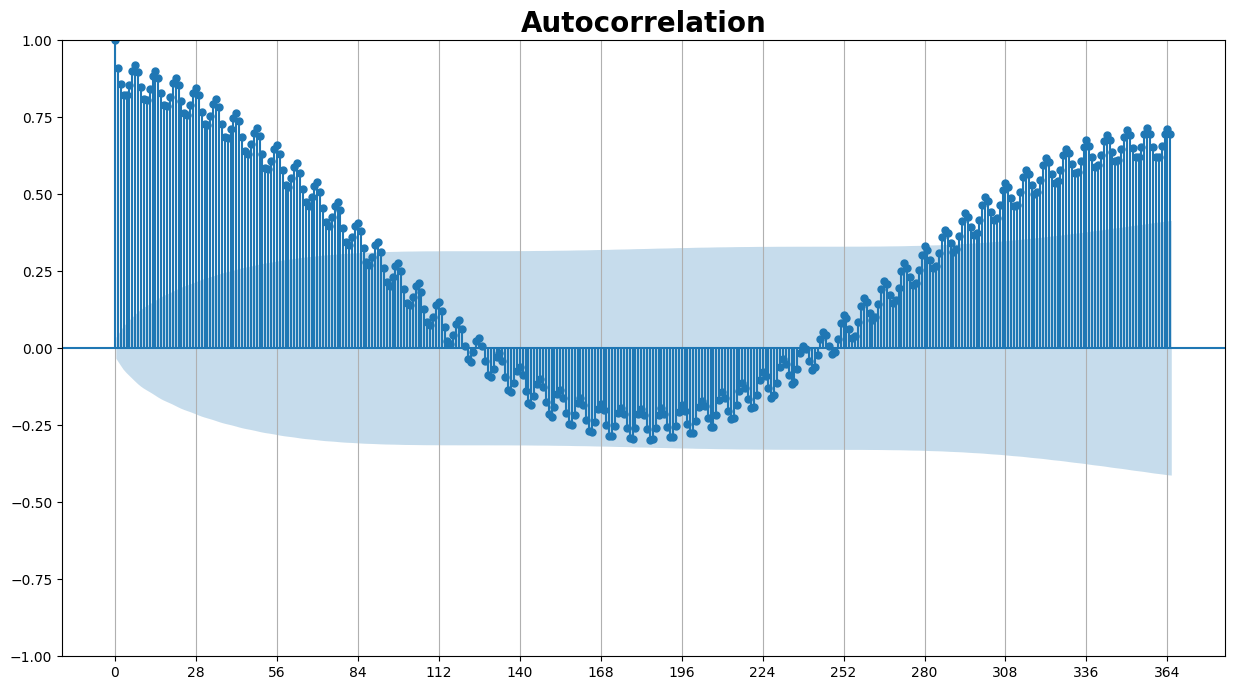

In [124]:
plot_acf(df, lags = 365)
plt.xticks(range(0,366,28))
plt.grid(True, axis = 'x')
plt.show()

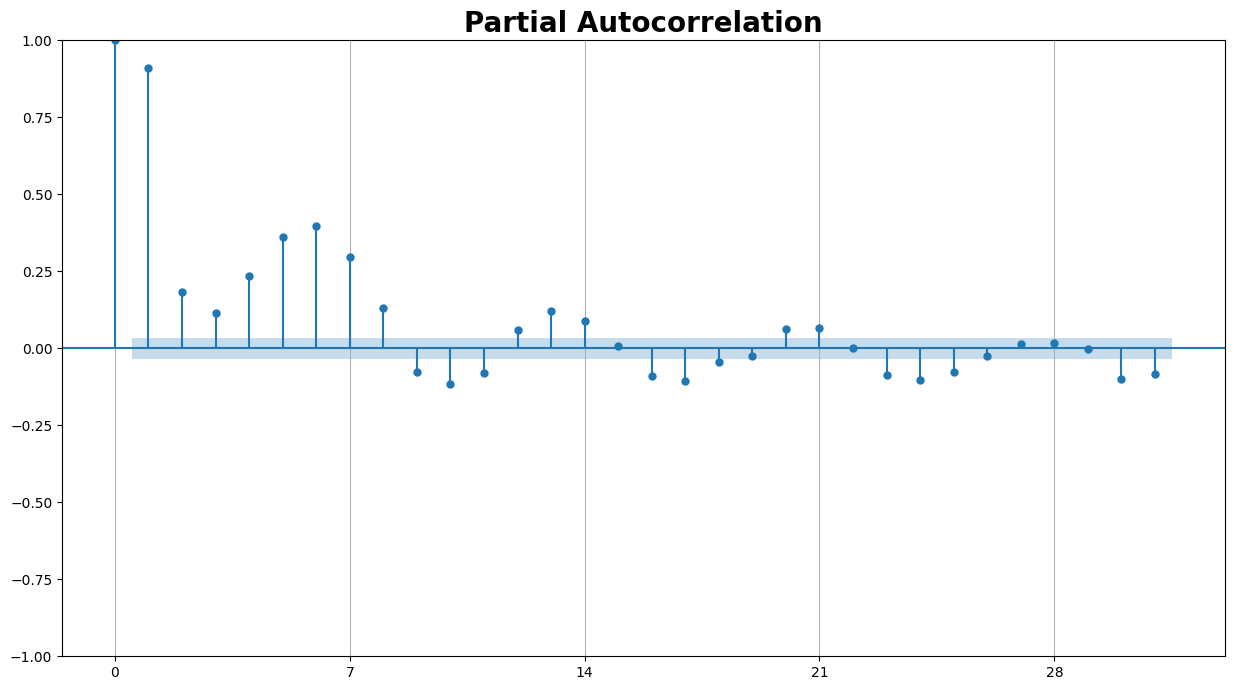

In [125]:
plot_pacf(df, lags = 31)
plt.xticks(range(0,32,7))
plt.grid(True, axis = 'x')
plt.show()

Тест

In [126]:
test = test.groupby(['Date']).agg({'number_sold':'sum'}).reset_index()
test['Date'] = pd.to_datetime(test['Date'], format = '%Y-%m-%d')
test.index = test['Date']
test.index.name = None
test = test.drop('Date', axis = 1)

In [127]:
test.head()

,number_sold
2019-01-01,55221
2019-01-02,55287
2019-01-03,55302
2019-01-04,55407
2019-01-05,55289


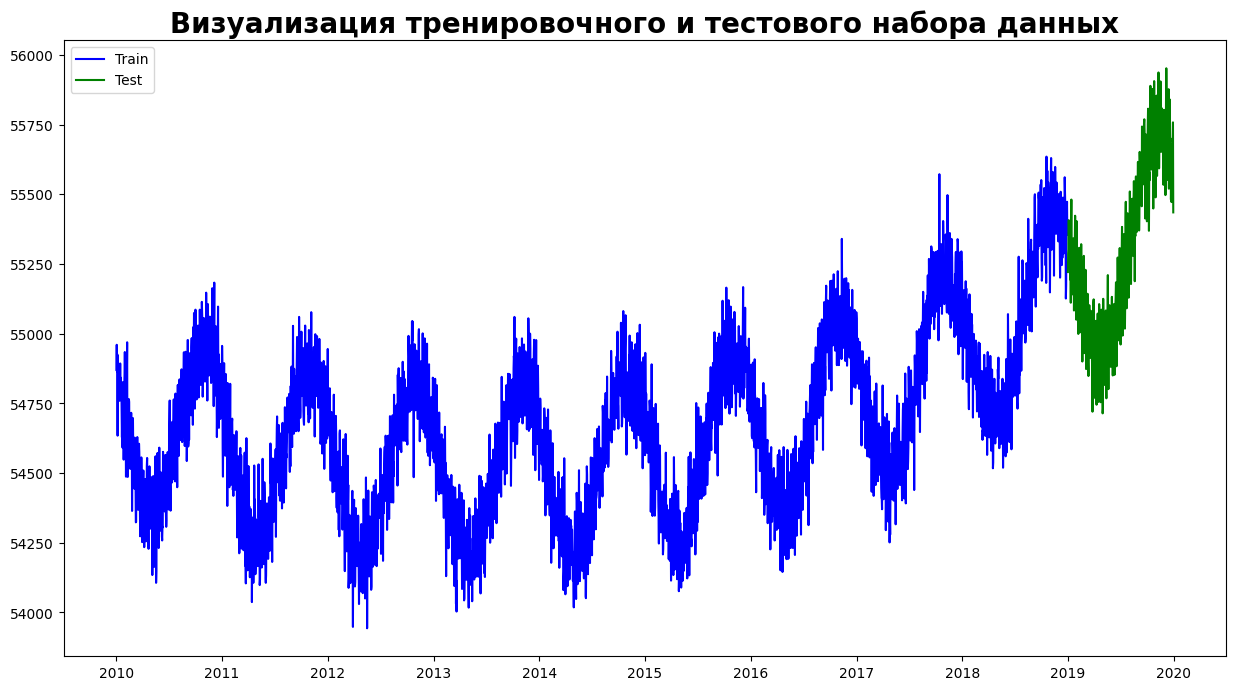

In [128]:
plt.plot(df, color = 'blue', label = 'Train')
plt.plot(test, color = 'green', label = 'Test')
plt.legend()
plt.title('Визуализация тренировочного и тестового набора данных')
plt.show()

Линейная регрессия

In [158]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

train.drop(['store', 'product'], axis = 1, inplace = True)
test.drop(['store', 'product'], axis = 1, inplace = True)

In [159]:
train['Date'] = pd.to_datetime(train['Date'], format = '%Y-%m-%d')
test['Date'] = pd.to_datetime(test['Date'], format = '%Y-%m-%d')

train.index = train['Date']
test.index = test['Date']

train.drop('Date', axis = 1, inplace = True)
test.drop('Date', axis = 1, inplace = True)

train.index.name = None
test.index.name = None

In [160]:
train = train.resample(rule = 'D').sum()
test = test.resample(rule = 'D').sum()

In [167]:
forecaster = ForecasterAutoreg(
    regressor = LinearRegression(),
    lags = 365)

forecaster.fit(train['number_sold'])
forecaster

ForecasterAutoreg 
Regressor: LinearRegression() 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233

In [168]:
steps = len(test)

y_pred = forecaster.predict(steps)
y_pred.head()

2019-01-01    55305.096743
2019-01-02    55245.610214
2019-01-03    55350.235052
2019-01-04    55418.349070
2019-01-05    55415.591237
Freq: D, Name: pred, dtype: float64

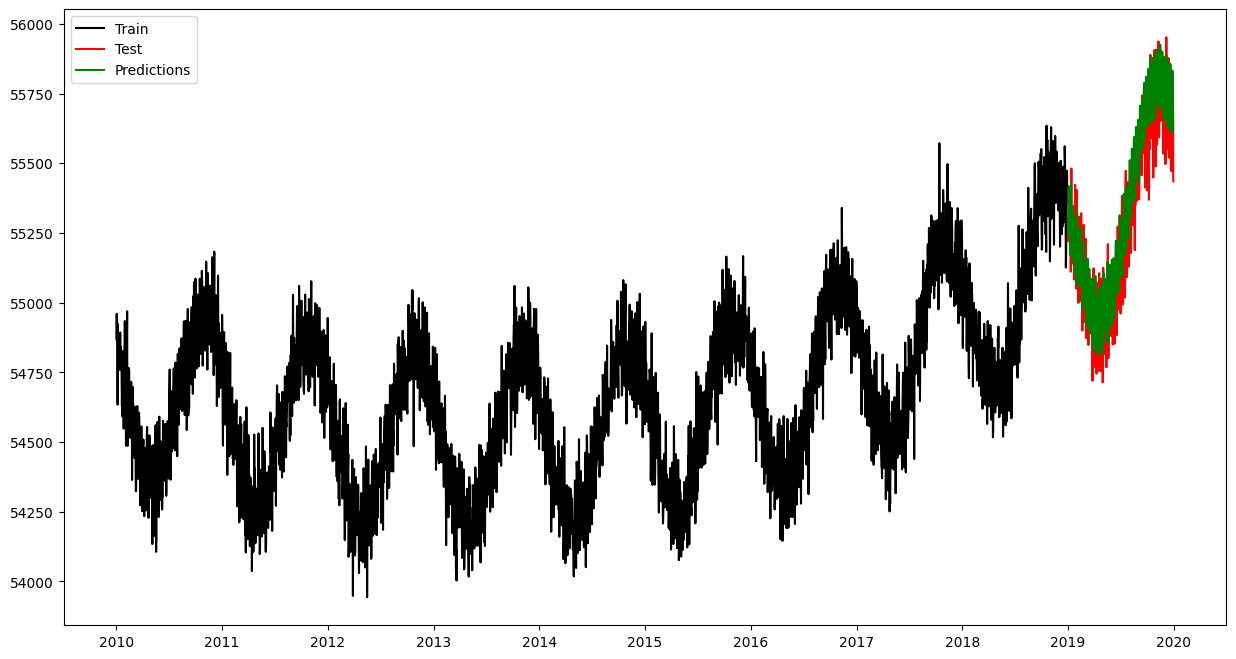

In [169]:
plt.plot(train, color = 'black', label = 'Train')
plt.plot(test, color = 'red', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'Predictions')

plt.legend()
plt.show()